<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Natural Language Processing (NLP) Review Lab

_Authors: Joseph Nelson (DC)_

---

> **Note: This lab is intended to be done as a walkthrough with the instructor.**

## Introduction


*Adapted from [NLP Crash Course](http://files.meetup.com/7616132/DC-NLP-2013-09%20Charlie%20Greenbacker.pdf) by Charlie Greenbacker, [Introduction to NLP](http://spark-public.s3.amazonaws.com/nlp/slides/intro.pdf) by Dan Jurafsky, Kevin Markham's Data School Curriculum*

### What is NLP?

- Using computers to process (analyze, understand, generate) natural human languages
- Most knowledge created by humans is unstructured text, and we need a way to make sense of it
- Build probabilistic model using data about a language

### What are some of the higher level task areas?

- **Information retrieval**: Find relevant results and similar results
    - [Google](https://www.google.com/)
- **Information extraction**: Structured information from unstructured documents
    - [Events from Gmail](https://support.google.com/calendar/answer/6084018?hl=en)
- **Machine translation**: One language to another
    - [Google Translate](https://translate.google.com/)
- **Text simplification**: Preserve the meaning of text, but simplify the grammar and vocabulary
    - [Rewordify](https://rewordify.com/)
    - [Simple English Wikipedia](https://simple.wikipedia.org/wiki/Main_Page)
- **Predictive text input**: Faster or easier typing
    - [My application](https://justmarkham.shinyapps.io/textprediction/)
    - [A much better application](https://farsite.shinyapps.io/swiftkey-cap/)
- **Sentiment analysis**: Attitude of speaker
    - [Hater News](http://haternews.herokuapp.com/)
- **Automatic summarization**: Extractive or abstractive summarization
    - [autotldr](https://www.reddit.com/r/technology/comments/35brc8/21_million_people_still_use_aol_dialup/cr2zzj0)
- **Natural Language Generation**: Generate text from data
    - [How a computer describes a sports match](http://www.bbc.com/news/technology-34204052)
    - [Publishers withdraw more than 120 gibberish papers](http://www.nature.com/news/publishers-withdraw-more-than-120-gibberish-papers-1.14763)
- **Speech recognition and generation**: Speech-to-text, text-to-speech
    - [Google's Web Speech API demo](https://www.google.com/intl/en/chrome/demos/speech.html)
    - [Vocalware Text-to-Speech demo](https://www.vocalware.com/index/demo)
- **Question answering**: Determine the intent of the question, match query with knowledge base, evaluate hypotheses
    - [How did supercomputer Watson beat Jeopardy champion Ken Jennings?](http://blog.ted.com/how-did-supercomputer-watson-beat-jeopardy-champion-ken-jennings-experts-discuss/)
    - [IBM's Watson Trivia Challenge](http://www.nytimes.com/interactive/2010/06/16/magazine/watson-trivia-game.html)
    - [The AI Behind Watson](http://www.aaai.org/Magazine/Watson/watson.php)

### What are some of the lower level components?

- **Tokenization**: breaking text into tokens (words, sentences, n-grams)
- **Stopword removal**: a/an/the
- **Stemming and lemmatization**: root word
- **TF-IDF**: word importance
- **Part-of-speech tagging**: noun/verb/adjective
- **Named entity recognition**: person/organization/location
- **Spelling correction**: "New Yrok City"
- **Word sense disambiguation**: "buy a mouse"
- **Segmentation**: "New York City subway"
- **Language detection**: "translate this page"
- **Machine learning**

### Why is NLP hard?

- **Ambiguity**:
    - Hospitals are Sued by 7 Foot Doctors
    - Juvenile Court to Try Shooting Defendant
    - Local High School Dropouts Cut in Half
- **Non-standard English**: text messages
- **Idioms**: "throw in the towel"
- **Newly coined words**: "retweet"
- **Tricky entity names**: "Where is A Bug's Life playing?"
- **World knowledge**: "Mary and Sue are sisters", "Mary and Sue are mothers"

NLP requires an understanding of the **language** and the **world**.

## Part 1: Reading in the Yelp Reviews

- "corpus" = collection of documents
- "corpora" = plural form of corpus

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

In [5]:
csv_file = '../datasets/yelp.csv'

In [6]:
yelp = pd.read_csv(csv_file)

In [7]:
yelp.head(3)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0


### 1.1 Subset the reviews to best and worst.

- Select only 5-star and 1-star reviews.
- The text will be the features, the stars will be the target.
- Create a train-test split.

In [8]:
# read yelp.csv into a DataFrame
yelp = pd.read_csv(csv_file)

# create a new DataFrame that only contains the 5-star and 1-star reviews
yelp_best_worst = yelp[(yelp.stars==5) | (yelp.stars==1)]

# define X and y
X = yelp_best_worst.text
y = yelp_best_worst.stars

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [11]:
yelp_best_worst.head(1).text

0    My wife took me here on my birthday for breakf...
Name: text, dtype: object

In [12]:
len(X_train), len(X_test)

(3064, 1022)

## Part 2: Tokenization

- **What:** Separate text into units such as sentences or words
- **Why:** Gives structure to previously unstructured text
- **Notes:** Relatively easy with English language text, not easy with some languages

### 2.1 Use CountVectorizer to convert the training and testing text data.

[CountVectorizer documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

- **lowercase:** boolean, True by default
    - Convert all characters to lowercase before tokenizing.
- **ngram_range:** tuple (min_n, max_n)
    - The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used.

In [13]:
# use CountVectorizer to create document-term matrices from X_train and X_test
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [14]:
# rows are documents, columns are terms (aka "tokens" or "features")
X_train_dtm.shape

(3064, 16825)

In [15]:
# last 50 features
vect.get_feature_names()[-50:]

['yyyyy',
 'z11',
 'za',
 'zabba',
 'zach',
 'zam',
 'zanella',
 'zankou',
 'zappos',
 'zatsiki',
 'zen',
 'zero',
 'zest',
 'zexperience',
 'zha',
 'zhou',
 'zia',
 'zihuatenejo',
 'zilch',
 'zin',
 'zinburger',
 'zinburgergeist',
 'zinc',
 'zinfandel',
 'zing',
 'zip',
 'zipcar',
 'zipper',
 'zippers',
 'zipps',
 'ziti',
 'zoe',
 'zombi',
 'zombies',
 'zone',
 'zones',
 'zoning',
 'zoo',
 'zoyo',
 'zucca',
 'zucchini',
 'zuchinni',
 'zumba',
 'zupa',
 'zuzu',
 'zwiebel',
 'zzed',
 'éclairs',
 'école',
 'ém']

In [16]:
# show vectorizer options
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [17]:
# don't convert to lowercase
vect = CountVectorizer(lowercase=False)
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm.shape

(3064, 20838)

In [18]:
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm.shape

(3064, 169847)

In [19]:
# last 50 features
vect.get_feature_names()[-50:]

['zone out',
 'zone when',
 'zones',
 'zones dolls',
 'zoning',
 'zoning issues',
 'zoo',
 'zoo and',
 'zoo is',
 'zoo not',
 'zoo the',
 'zoo ve',
 'zoyo',
 'zoyo for',
 'zucca',
 'zucca appetizer',
 'zucchini',
 'zucchini and',
 'zucchini bread',
 'zucchini broccoli',
 'zucchini carrots',
 'zucchini fries',
 'zucchini pieces',
 'zucchini strips',
 'zucchini veal',
 'zucchini very',
 'zucchini with',
 'zuchinni',
 'zuchinni again',
 'zuchinni the',
 'zumba',
 'zumba class',
 'zumba or',
 'zumba yogalates',
 'zupa',
 'zupa flavors',
 'zuzu',
 'zuzu in',
 'zuzu is',
 'zuzu the',
 'zwiebel',
 'zwiebel kräuter',
 'zzed',
 'zzed in',
 'éclairs',
 'éclairs napoleons',
 'école',
 'école lenôtre',
 'ém',
 'ém all']

### 2.2 Predict the star rating with the new features from CountVectorizer.

Validate on the test set.

In [21]:
# use default options for CountVectorizer
vect = CountVectorizer()

# create document-term matrices
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

# use Naive Bayes  to predict the star rating
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

# calculate accuracy
print(metrics.accuracy_score(y_test, y_pred_class))

0.9187866927592955


In [22]:
# calculate null accuracy
y_test_binary = np.where(y_test==5, 1, 0)
max(y_test_binary.mean(), 1 - y_test_binary.mean())

0.8199608610567515

In [23]:
# define a function that accepts a vectorizer and calculates the accuracy
def tokenize_test(vect):
    X_train_dtm = vect.fit_transform(X_train)
    print('Features: ', X_train_dtm.shape[1])
    X_test_dtm = vect.transform(X_test)
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))

In [24]:
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))
tokenize_test(vect)

Features:  169847
Accuracy:  0.8542074363992173


## Part 3: Stopword Removal

- **What:** Remove common words that will likely appear in any text
- **Why:** They don't tell you much about your text

### 3.1 Recreate your features with CountVectorizer removing stopwords.

- **stop_words:** string {'english'}, list, or None (default)
- If 'english', a built-in stop word list for English is used.
- If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens.
- If None, no stop words will be used. max_df can be set to a value in the range [0.7, 1.0) to automatically detect and filter stop words based on intra corpus document frequency of terms.

In [25]:
# show vectorizer options
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [26]:
# remove English stop words
vect = CountVectorizer(stop_words='english')

### 3.2 Validate your model using the features with stopwords removed.

In [27]:
tokenize_test(vect)

Features:  16528
Accuracy:  0.9158512720156555


In [29]:
# set of stop words
print(vect.get_stop_words())

frozenset({'around', 'much', 'nobody', 'every', 'under', 'what', 'indeed', 'mill', 'or', 'moreover', 'namely', 'few', 'find', 'please', 'where', 'them', 'yourself', 'herein', 'otherwise', 'alone', 'beyond', 'very', 'while', 'with', 'interest', 'some', 'who', 'be', 'call', 'seemed', 'they', 'un', 'should', 'was', 'below', 'either', 'become', 'never', 'six', 'whereas', 'still', 'enough', 'give', 'when', 'wherever', 'whither', 'that', 'but', 'one', 'neither', 'anywhere', 'out', 'everywhere', 'well', 'could', 'whose', 'four', 'yourselves', 'full', 'as', 'thick', 'before', 'anyone', 'meanwhile', 'amoungst', 'became', 'been', 'more', 'myself', 'nevertheless', 'often', 'if', 'own', 'amongst', 'on', 'side', 'us', 'becoming', 'themselves', 'being', 'top', 'part', 'without', 'thereafter', 'within', 'himself', 'during', 'besides', 'fill', 'last', 'yours', 'would', 'i', 'take', 'how', 'though', 'itself', 'such', 'anyhow', 'seem', 'this', 'whereupon', 'anyway', 'elsewhere', 'has', 'forty', 'de', 'o

## Part 4: Other CountVectorizer Options

### 4.1 Shrink the maximum number of features and re-test the model.

- **max_features:** int or None, default=None
- If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

In [30]:
# remove English stop words and only keep 100 features
vect = CountVectorizer(stop_words='english', max_features=100)
tokenize_test(vect)

Features:  100
Accuracy:  0.8698630136986302


In [31]:
# all 100 features
print(vect.get_feature_names())

['amazing', 'area', 'atmosphere', 'awesome', 'bad', 'bar', 'best', 'better', 'big', 'came', 'cheese', 'chicken', 'clean', 'coffee', 'come', 'day', 'definitely', 'delicious', 'did', 'didn', 'dinner', 'don', 'eat', 'excellent', 'experience', 'favorite', 'feel', 'food', 'free', 'fresh', 'friendly', 'friends', 'going', 'good', 'got', 'great', 'happy', 'home', 'hot', 'hour', 'just', 'know', 'like', 'little', 'll', 'location', 'long', 'looking', 'lot', 'love', 'lunch', 'make', 'meal', 'menu', 'minutes', 'need', 'new', 'nice', 'night', 'order', 'ordered', 'people', 'perfect', 'phoenix', 'pizza', 'place', 'pretty', 'prices', 'really', 'recommend', 'restaurant', 'right', 'said', 'salad', 'sandwich', 'sauce', 'say', 'service', 'staff', 'store', 'sure', 'table', 'thing', 'things', 'think', 'time', 'times', 'took', 'town', 'tried', 'try', 've', 'wait', 'want', 'way', 'went', 'wine', 'work', 'worth', 'years']


In [32]:
# include 1-grams and 2-grams, and limit the number of features
vect = CountVectorizer(ngram_range=(1, 2), max_features=100000)
tokenize_test(vect)

Features:  100000
Accuracy:  0.8855185909980431


### 4.2 Change the minimum document frequency for terms and test the model's performance.

- **min_df:** float in range [0.0, 1.0] or int, default=1
- When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts.

In [33]:
# include 1-grams and 2-grams, and only include terms that appear at least 2 times
vect = CountVectorizer(ngram_range=(1, 2), min_df=2)
tokenize_test(vect)

Features:  43957
Accuracy:  0.9324853228962818


## Part 5: Introduction to TextBlob

TextBlob: "Simplified Text Processing"

### 5.1 Use `TextBlob` to convert the text in the first review in the dataset.

In [34]:
# print the first review
print(yelp_best_worst.text[0])

My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.

Do yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I've ever had.  I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.

While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I've ever had.

Anyway, I can't wait to go back!


In [35]:
# save it as a TextBlob object
review = TextBlob(yelp_best_worst.text[0])

### 5.2 List the words in the `TextBlob` object.

In [36]:
# list the words
review.words

WordList(['My', 'wife', 'took', 'me', 'here', 'on', 'my', 'birthday', 'for', 'breakfast', 'and', 'it', 'was', 'excellent', 'The', 'weather', 'was', 'perfect', 'which', 'made', 'sitting', 'outside', 'overlooking', 'their', 'grounds', 'an', 'absolute', 'pleasure', 'Our', 'waitress', 'was', 'excellent', 'and', 'our', 'food', 'arrived', 'quickly', 'on', 'the', 'semi-busy', 'Saturday', 'morning', 'It', 'looked', 'like', 'the', 'place', 'fills', 'up', 'pretty', 'quickly', 'so', 'the', 'earlier', 'you', 'get', 'here', 'the', 'better', 'Do', 'yourself', 'a', 'favor', 'and', 'get', 'their', 'Bloody', 'Mary', 'It', 'was', 'phenomenal', 'and', 'simply', 'the', 'best', 'I', "'ve", 'ever', 'had', 'I', "'m", 'pretty', 'sure', 'they', 'only', 'use', 'ingredients', 'from', 'their', 'garden', 'and', 'blend', 'them', 'fresh', 'when', 'you', 'order', 'it', 'It', 'was', 'amazing', 'While', 'EVERYTHING', 'on', 'the', 'menu', 'looks', 'excellent', 'I', 'had', 'the', 'white', 'truffle', 'scrambled', 'eggs', 

### 5.3 List the sentences in the `TextBlob` object.

In [37]:
# list the sentences
review.sentences

[Sentence("My wife took me here on my birthday for breakfast and it was excellent."),
 Sentence("The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure."),
 Sentence("Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning."),
 Sentence("It looked like the place fills up pretty quickly so the earlier you get here the better."),
 Sentence("Do yourself a favor and get their Bloody Mary."),
 Sentence("It was phenomenal and simply the best I've ever had."),
 Sentence("I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it."),
 Sentence("It was amazing."),
 Sentence("While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious."),
 Sentence("It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete."),
 Sentence("It was the best "toast" I've ever had."),


In [38]:
# some string methods are available
review.lower()

TextBlob("my wife took me here on my birthday for breakfast and it was excellent.  the weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  our waitress was excellent and our food arrived quickly on the semi-busy saturday morning.  it looked like the place fills up pretty quickly so the earlier you get here the better.

do yourself a favor and get their bloody mary.  it was phenomenal and simply the best i've ever had.  i'm pretty sure they only use ingredients from their garden and blend them fresh when you order it.  it was amazing.

while everything on the menu looks excellent, i had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  it came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  it was the best "toast" i've ever had.

anyway, i can't wait to go back!")

## Part 6: Stemming and Lemmatization

**Stemming:**

- **What:** Reduce a word to its base/stem/root form
- **Why:** Often makes sense to treat related words the same way
- **Notes:**
    - Uses a "simple" and fast rule-based approach
    - Stemmed words are usually not shown to users (used for analysis/indexing)
    - Some search engines treat words with the same stem as synonyms

### 6.1 Initialize the `SnowballStemmer` and stem the words in the first review.

In [39]:
# initialize stemmer
stemmer = SnowballStemmer('english')

# stem each word
print([stemmer.stem(word) for word in review.words])

['my', 'wife', 'took', 'me', 'here', 'on', 'my', 'birthday', 'for', 'breakfast', 'and', 'it', 'was', 'excel', 'the', 'weather', 'was', 'perfect', 'which', 'made', 'sit', 'outsid', 'overlook', 'their', 'ground', 'an', 'absolut', 'pleasur', 'our', 'waitress', 'was', 'excel', 'and', 'our', 'food', 'arriv', 'quick', 'on', 'the', 'semi-busi', 'saturday', 'morn', 'it', 'look', 'like', 'the', 'place', 'fill', 'up', 'pretti', 'quick', 'so', 'the', 'earlier', 'you', 'get', 'here', 'the', 'better', 'do', 'yourself', 'a', 'favor', 'and', 'get', 'their', 'bloodi', 'mari', 'it', 'was', 'phenomen', 'and', 'simpli', 'the', 'best', 'i', 've', 'ever', 'had', 'i', "'m", 'pretti', 'sure', 'they', 'onli', 'use', 'ingredi', 'from', 'their', 'garden', 'and', 'blend', 'them', 'fresh', 'when', 'you', 'order', 'it', 'it', 'was', 'amaz', 'while', 'everyth', 'on', 'the', 'menu', 'look', 'excel', 'i', 'had', 'the', 'white', 'truffl', 'scrambl', 'egg', 'veget', 'skillet', 'and', 'it', 'was', 'tasti', 'and', 'delic

### 6.2 Use the built-in `lemmatize` function on the words of the first review (parsed by `TextBlob`)

**Lemmatization**

- **What:** Derive the canonical form ('lemma') of a word
- **Why:** Can be better than stemming
- **Notes:** Uses a dictionary-based approach (slower than stemming)

In [40]:
# assume every word is a noun
print([word.lemmatize() for word in review.words])

['My', 'wife', 'took', 'me', 'here', 'on', 'my', 'birthday', 'for', 'breakfast', 'and', 'it', 'wa', 'excellent', 'The', 'weather', 'wa', 'perfect', 'which', 'made', 'sitting', 'outside', 'overlooking', 'their', 'ground', 'an', 'absolute', 'pleasure', 'Our', 'waitress', 'wa', 'excellent', 'and', 'our', 'food', 'arrived', 'quickly', 'on', 'the', 'semi-busy', 'Saturday', 'morning', 'It', 'looked', 'like', 'the', 'place', 'fill', 'up', 'pretty', 'quickly', 'so', 'the', 'earlier', 'you', 'get', 'here', 'the', 'better', 'Do', 'yourself', 'a', 'favor', 'and', 'get', 'their', 'Bloody', 'Mary', 'It', 'wa', 'phenomenal', 'and', 'simply', 'the', 'best', 'I', "'ve", 'ever', 'had', 'I', "'m", 'pretty', 'sure', 'they', 'only', 'use', 'ingredient', 'from', 'their', 'garden', 'and', 'blend', 'them', 'fresh', 'when', 'you', 'order', 'it', 'It', 'wa', 'amazing', 'While', 'EVERYTHING', 'on', 'the', 'menu', 'look', 'excellent', 'I', 'had', 'the', 'white', 'truffle', 'scrambled', 'egg', 'vegetable', 'skill

In [41]:
# assume every word is a verb
print([word.lemmatize(pos='v') for word in review.words])

['My', 'wife', 'take', 'me', 'here', 'on', 'my', 'birthday', 'for', 'breakfast', 'and', 'it', 'be', 'excellent', 'The', 'weather', 'be', 'perfect', 'which', 'make', 'sit', 'outside', 'overlook', 'their', 'ground', 'an', 'absolute', 'pleasure', 'Our', 'waitress', 'be', 'excellent', 'and', 'our', 'food', 'arrive', 'quickly', 'on', 'the', 'semi-busy', 'Saturday', 'morning', 'It', 'look', 'like', 'the', 'place', 'fill', 'up', 'pretty', 'quickly', 'so', 'the', 'earlier', 'you', 'get', 'here', 'the', 'better', 'Do', 'yourself', 'a', 'favor', 'and', 'get', 'their', 'Bloody', 'Mary', 'It', 'be', 'phenomenal', 'and', 'simply', 'the', 'best', 'I', "'ve", 'ever', 'have', 'I', "'m", 'pretty', 'sure', 'they', 'only', 'use', 'ingredients', 'from', 'their', 'garden', 'and', 'blend', 'them', 'fresh', 'when', 'you', 'order', 'it', 'It', 'be', 'amaze', 'While', 'EVERYTHING', 'on', 'the', 'menu', 'look', 'excellent', 'I', 'have', 'the', 'white', 'truffle', 'scramble', 'egg', 'vegetable', 'skillet', 'and'

### 6.3 Write a function that uses `TextBlob` and `lemmatize` to lemmatize text.

In [45]:
# define a function that accepts text and returns a list of lemmas
def split_into_lemmas(text):
    text = text.lower()
    words = TextBlob(text).words
    return [word.lemmatize() for word in words]

### 6.4 Provide your function to `CountVectorizer` as the `analyzer` and test the performance of your model.

In [46]:
# use split_into_lemmas as the feature extraction function (WARNING: SLOW!)
vect = CountVectorizer(analyzer=split_into_lemmas)
tokenize_test(vect)

Features:  16452
Accuracy:  0.9207436399217221


In [47]:
# last 50 features
print(vect.get_feature_names()[-50:])

['yuyuyummy', 'yuzu', 'z', 'z-grill', 'z11', 'zach', 'zam', 'zanella', 'zankou', 'zappos', 'zatsiki', 'zen', 'zen-like', 'zero', 'zero-star', 'zest', 'zexperience', 'zha', 'zhou', 'zia', 'zilch', 'zin', 'zinburger', 'zinburgergeist', 'zinc', 'zinfandel', 'zing', 'zip', 'zipcar', 'zipper', 'zipps', 'ziti', 'zoe', 'zombi', 'zombie', 'zone', 'zoning', 'zoo', 'zoyo', 'zucca', 'zucchini', 'zuchinni', 'zumba', 'zupa', 'zuzu', 'zwiebel-kräuter', 'zzed', 'éclairs', 'école', 'ém']


## Part 7: Term Frequency-Inverse Document Frequency (TF-IDF)

- **What:** Computes "relative frequency" that a word appears in a document compared to its frequency across all documents
- **Why:** More useful than "term frequency" for identifying "important" words in each document (high frequency in that document, low frequency in other documents)
- **Notes:** Used for search engine scoring, text summarization, document clustering

### 7.1 Build a simple TF-IDF using CountVectorizer

- Term Frequency can be calulated with default CountVectorizer.
- Inverse Document Frequency can be calculated with CountVectorizer and argument `binary=True`.

**More details:** [TF-IDF is about what matters](http://planspace.org/20150524-tfidf_is_about_what_matters/)

In [48]:
# example documents
simple_train = ['call you tonight', 'Call me a cab', 'please call me... PLEASE!']

In [49]:
# Term Frequency
vect = CountVectorizer()
tf = pd.DataFrame(vect.fit_transform(simple_train).toarray(), columns=vect.get_feature_names())
tf

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


In [50]:
# Document Frequency
vect = CountVectorizer(binary=True)
df = vect.fit_transform(simple_train).toarray().sum(axis=0)
pd.DataFrame(df.reshape(1, 6), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,1,3,2,1,1,1


In [51]:
# Term Frequency-Inverse Document Frequency (simple version)
tf/df

,cab,call,me,please,tonight,you
0,0.0,0.333333,0.0,0.0,1.0,1.0
1,1.0,0.333333,0.5,0.0,0.0,0.0
2,0.0,0.333333,0.5,2.0,0.0,0.0


In [52]:
# TfidfVectorizer
vect = TfidfVectorizer()
pd.DataFrame(vect.fit_transform(simple_train).toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0.000000,0.385372,0.000000,0.000000,0.652491,0.652491
1,0.720333,0.425441,0.547832,0.000000,0.000000,0.000000
2,0.000000,0.266075,0.342620,0.901008,0.000000,0.000000


## Part 8: Using TF-IDF to Summarize a Yelp Review

> **Note:** Reddit's autotldr uses the [SMMRY](http://smmry.com/about) algorithm, which is based on TF-IDF!

### 8.1 Build a TF-IDF predictor matrix excluding stopwords with `TfidfVectorizer`

In [53]:
# create a document-term matrix using TF-IDF
vect = TfidfVectorizer(stop_words='english')
dtm = vect.fit_transform(yelp.text)
features = vect.get_feature_names()
dtm.shape

(10000, 28880)

### 8.2 Write a function to pull out the top 5 words by TF-IDF score from a review

In [60]:
def summarize():
    
    # choose a random review that is at least 300 characters
    review_length = 0
    while review_length < 300:
        review_id = np.random.randint(0, len(yelp))
        review_text = yelp.text[review_id]
        review_length = len(review_text)
    
    # create a dictionary of words and their TF-IDF scores
    word_scores = {}
    for word in TextBlob(review_text).words:
        word = word.lower()
        if word in features:
            word_scores[word] = dtm[review_id, features.index(word)]
    
    # print words with the top 5 TF-IDF scores
    print('TOP SCORING WORDS:')
    top_scores = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:5]
    for word, score in top_scores:
        print(word)
    
    # print 5 random words
    print('\n' + 'RANDOM WORDS:')
    random_words = np.random.choice(list(word_scores.keys()), size=5, replace=False)
    for word in random_words:
        print(word)
    
    # print the review
    print('\n' + review_text)

In [61]:
summarize()

TOP SCORING WORDS:
knots
pizza
appetizing
solution
takeout

RANDOM WORDS:
dough
called
appetizing
time
credit

Not impressed. Tried them for the first time ordering takeout. Quick delivery, but the pizza and garlic knots were not cooked completely. Raw dough was not very appetizing.  I called the manager to let them know, he offered to give me credit, but a better solution would have been to cook another pizza and deliver it again.  Not sure if we'll order from them again.


## Part 9: Sentiment Analysis

### 9.1 Extract sentiment from a review parsed with `TextBlob`

Sentiment polarity ranges from -1, the most negative, to 1, the most positive. A parsed TextBlob object has sentiment which can be accessed with:

    review.sentiment.polarity

In [62]:
review

TextBlob("My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.

Do yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I've ever had.  I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.

While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I've ever had.

Anyway, I can't wait to go back!")

In [63]:
# polarity ranges from -1 (most negative) to 1 (most positive)
review.sentiment.polarity

0.40246913580246907

### 9.2 Calculate the sentiment for every review in the full Yelp dataset as a new column.

In [68]:
# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [69]:
# create a new DataFrame column for sentiment (WARNING: SLOW!)
yelp['sentiment'] = yelp['text'].apply(detect_sentiment)

In [70]:
yelp.columns

Index(['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id',
       'cool', 'useful', 'funny', 'sentiment'],
      dtype='object')

In [73]:
yelp_best_worst = yelp[(yelp['stars']==5) | (yelp['stars']==1)]

### 9.3 Create a boxplot of sentiment by star rating

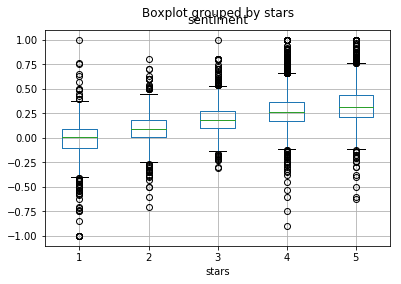

In [74]:
# box plot of sentiment grouped by stars
yelp.boxplot(column='sentiment', by='stars')

### 9.4 Print reviews with the highest and lowest sentiment.

In [77]:
# reviews with most positive sentiment
yelp[yelp['sentiment'] == 1]['text'].head()

254    Our server Gary was awesome. Food was amazing....
347    3 syllables for this place. \nA-MAZ-ING!\n\nTh...
420                                    LOVE the food!!!!
459    Love it!!! Wish we still lived in Arizona as C...
679                                     Excellent burger
Name: text, dtype: object

In [78]:
# reviews with most negative sentiment
yelp[yelp['sentiment'] == -1]['text'].head()

773     This was absolutely horrible. I got the suprem...
1517                  Nasty workers and over priced trash
3266    Absolutely awful... these guys have NO idea wh...
4766                                       Very bad food!
5812        I wouldn't send my worst enemy to this place.
Name: text, dtype: object

## 10. [Bonus] Explore fun TextBlob features

### 10.1 Correct spelling with `.correct()`

In [79]:
# spelling correction
TextBlob('15 minuets late').correct()

TextBlob("15 minutes late")

### 10.2 Perform spellchecking with `.spellcheck()`

In [80]:
# spellcheck
Word('parot').spellcheck()

[('part', 0.9929478138222849), ('parrot', 0.007052186177715092)]

### 10.3 Extract definitions with `.define()`

In [81]:
# definitions
Word('bank').define('n')

['sloping land (especially the slope beside a body of water)',
 'a financial institution that accepts deposits and channels the money into lending activities',
 'a long ridge or pile',
 'an arrangement of similar objects in a row or in tiers',
 'a supply or stock held in reserve for future use (especially in emergencies)',
 'the funds held by a gambling house or the dealer in some gambling games',
 'a slope in the turn of a road or track; the outside is higher than the inside in order to reduce the effects of centrifugal force',
 'a container (usually with a slot in the top) for keeping money at home',
 'a building in which the business of banking transacted',
 'a flight maneuver; aircraft tips laterally about its longitudinal axis (especially in turning)']

## Conclusion

- NLP is a gigantic field
- Understanding the basics broadens the types of data you can work with
- Simple techniques go a long way
- Use scikit-learn for NLP whenever possible